데이터 로드 및 확인

In [57]:
import pandas as pd

pca_result = pd.read_csv('./data/minmax_scaling_PCA.csv', index_col=0)
pca_result.head(5)

,0,1,2,3,4,5
행정동명,,,,,,
가락1동,0.313751,-0.194982,-0.059432,-0.178299,0.034524,-0.083174
가락2동,0.416137,-0.051024,0.035967,-0.002984,-0.078425,0.073808
가락본동,0.156997,0.112429,0.042758,0.028743,-0.027314,0.151885
가리봉동,-0.612605,0.107408,-0.156476,0.051506,-0.025351,-0.021620
가산동,-0.117360,0.795470,0.181084,-0.224243,0.009892,-0.060995


## clustering

- 최적의 군집 개수 구하기_ elbow

KElbowVisualizer(ax=<Axes: >,
                 estimator=KMeans(n_clusters=9, n_init=10, random_state=0),
                 k=(1, 10))

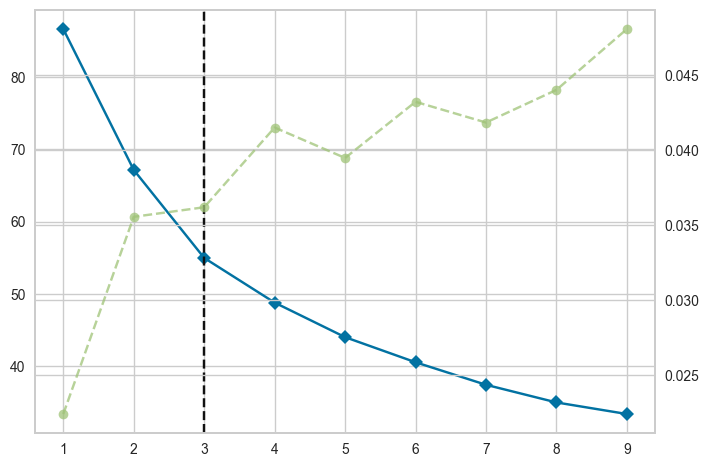

In [58]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

#엘보우 최적 클러스터 수 정하기
kmeans = KMeans(
                init='k-means++',   # K-means 알고리즘 설정
                max_iter=300,       # 최대 몇번 반복 
                tol=1e-4,
                n_init=10,
                random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(pca_result)

- 최적의 군집 개수 구하기_ 실루엣 계수

In [59]:
# 실루엣 계수 구하는 함수 설정
from sklearn.metrics import silhouette_samples
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def silhouette_avg(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    return cluster_labels, yticks, silhoutte_avg

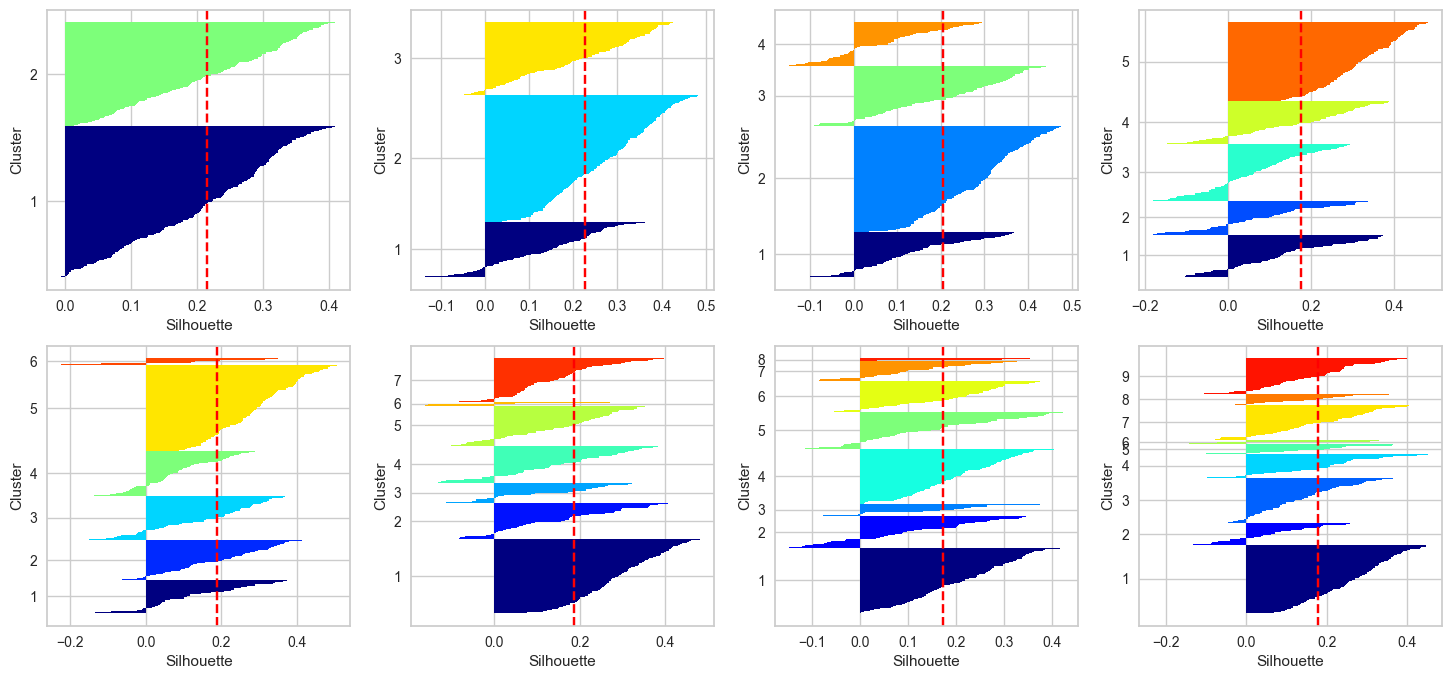

In [60]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

nrows, ncols = 2, 4
fig, ax = plt.subplots(nrows=nrows,
                       ncols=ncols,
                       figsize=(18,8))
for i, n_cluster in enumerate(n_clusters):
    kmeans= KMeans(n_clusters=n_cluster,
                   n_init=10,
                    init='k-means++',
                    max_iter=300,
                    tol=1e-4,
                    random_state=0)
    kmeans.fit(pca_result)

    
    plt.subplot(nrows, ncols, i+1)
    cluster_labels, yticks, silhoutte_score = silhouette_avg(pca_result, kmeans.labels_)
    
    plt.axvline(silhoutte_score, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette')
    
plt.show()

- kmeans 클러스터링 군집 4개로 설정하고 분석 실행

In [61]:
k_cluster = 4
kmeans = KMeans(n_clusters=k_cluster, # 클러스터 개수
                init='k-means++',     # K-means 알고리즘 설정
                max_iter=300,         # 최대 몇번 반복 
                tol=1e-4,
                n_init=10,
                random_state=0)

y_km = kmeans.fit_predict(pca_result)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

#실루엣 분석
silhouette_vals = silhouette_samples(pca_result, y_km, metric = 'euclidean')
#실루엣계수 평균값
silhouette_avg = np.mean(silhouette_vals)

#라벨링
pca_result['cluster'] = kmeans.labels_

print(f"군집의 총 개수: {n_clusters}개\n")
for i in range(k_cluster):
    print(f"cluster_{i}의 개수: {len(pca_result[pca_result['cluster'] == i].index)}개")

군집의 총 개수: 4개

cluster_0의 개수: 76개
cluster_1의 개수: 177개
cluster_2의 개수: 100개
cluster_3의 개수: 73개


- 주성분 1, 2 축으로 군집 시각화하기

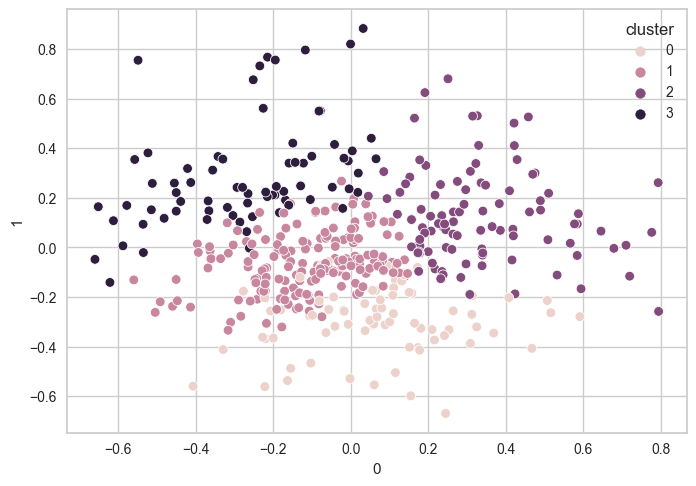

In [62]:
import seaborn as sns

sns.scatterplot(data = pca_result, x = '0', y = '1', hue = 'cluster')
plt.show()

In [63]:
pca_result.head()

,0,1,2,3,4,5,cluster
행정동명,,,,,,,
가락1동,0.313751,-0.194982,-0.059432,-0.178299,0.034524,-0.083174,0
가락2동,0.416137,-0.051024,0.035967,-0.002984,-0.078425,0.073808,2
가락본동,0.156997,0.112429,0.042758,0.028743,-0.027314,0.151885,2
가리봉동,-0.612605,0.107408,-0.156476,0.051506,-0.025351,-0.021620,3
가산동,-0.117360,0.795470,0.181084,-0.224243,0.009892,-0.060995,3


In [83]:
# 클러스터링 레이블이 포함된 데이터 내보내기
pca_result.to_csv('./data/minmax_scaling_PCA_label.csv')

In [78]:
# kmeans centroid 값 내보내기
centroids = kmeans.cluster_centers_
np.save('./data/kmeans_centroid', centroids)

In [81]:
np.load('./data/kmeans_centroid.npy')

array([[ 0.07141843, -0.29727122,  0.12185668, -0.073126  , -0.00813568,
        -0.00177339],
       [-0.10812752, -0.06308341, -0.08578103,  0.03118397,  0.02668824,
        -0.00076461],
       [ 0.33166693,  0.12469677,  0.00397283,  0.04099824, -0.01286504,
         0.00571944],
       [-0.2665195 ,  0.29162602,  0.07568289, -0.05564125, -0.03861648,
        -0.00413467]])